# QB vs RB Model

## Import Packages

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

2024-12-15 12:31:50.584487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import and Preprocess Data

In [2]:
input_df = pd.read_csv('Heisman_Winner_QB_vs_RB_Import.csv')
#print(input_data_cv.head())

#Standardize stats by # of games played
input_df['Pass_Cmp_per_Game_1'] = input_df['Pass_Cmp_1']/input_df['QB_Games_1']
input_df['Pass_Att_per_Game_1'] = input_df['Pass_Att_1']/input_df['QB_Games_1']
input_df['Pass_TD_per_Game_1'] = input_df['Pass_TD_1']/input_df['QB_Games_1']
input_df['Int_per_Game_1'] = input_df['Int_1']/input_df['QB_Games_1']

input_df['Pass_Cmp_per_Game_2'] = input_df['Pass_Cmp_2']/input_df['QB_Games_2']
input_df['Pass_Att_per_Game_2'] = input_df['Pass_Att_2']/input_df['QB_Games_2']
input_df['Pass_TD_per_Game_2'] = input_df['Pass_TD_2']/input_df['QB_Games_2']
input_df['Int_per_Game_2'] = input_df['Int_2']/input_df['QB_Games_2']

input_df['Pass_Cmp_per_Game_3'] = input_df['Pass_Cmp_3']/input_df['QB_Games_3']
input_df['Pass_Att_per_Game_3'] = input_df['Pass_Att_3']/input_df['QB_Games_3']
input_df['Pass_TD_per_Game_3'] = input_df['Pass_TD_3']/input_df['QB_Games_3']
input_df['Int_per_Game_3'] = input_df['Int_3']/input_df['QB_Games_3']

input_df['Rush_Att_per_Game_1'] = input_df['Rush_Att_1']/input_df['RB_Games_1']
input_df['Rush_Yds_per_Game_1'] = input_df['Rush_Yds_1']/input_df['RB_Games_1']
input_df['Rush_TD_per_Game_1'] = input_df['Rush_TD_1']/input_df['RB_Games_1']
input_df['Rec_per_Game_1'] = input_df['Rec_1']/input_df['RB_Games_1']
input_df['Rcv_Yds_per_Game_1'] = input_df['Rcv_Yds_1']/input_df['RB_Games_1']
input_df['Rcv_TD_per_Game_1'] = input_df['Rcv_TD_1']/input_df['RB_Games_1']
input_df['ScrmgPlays_per_Game_1'] = input_df['ScrmgPlays_1']/input_df['RB_Games_1']
input_df['Scrmg_Yds_per_Game_1'] = input_df['Scrmg_Yds_1']/input_df['RB_Games_1']
input_df['Scrmg_TD_per_Game_1'] = input_df['Scrmg_TD_1']/input_df['RB_Games_1']

input_df['Rush_Att_per_Game_2'] = input_df['Rush_Att_2']/input_df['RB_Games_2']
input_df['Rush_Yds_per_Game_2'] = input_df['Rush_Yds_2']/input_df['RB_Games_2']
input_df['Rush_TD_per_Game_2'] = input_df['Rush_TD_2']/input_df['RB_Games_2']
input_df['Rec_per_Game_2'] = input_df['Rec_2']/input_df['RB_Games_2']
input_df['Rcv_Yds_per_Game_2'] = input_df['Rcv_Yds_2']/input_df['RB_Games_2']
input_df['Rcv_TD_per_Game_2'] = input_df['Rcv_TD_2']/input_df['RB_Games_2']
input_df['ScrmgPlays_per_Game_2'] = input_df['ScrmgPlays_2']/input_df['RB_Games_2']
input_df['Scrmg_Yds_per_Game_2'] = input_df['Scrmg_Yds_2']/input_df['RB_Games_2']
input_df['Scrmg_TD_per_Game_2'] = input_df['Scrmg_TD_2']/input_df['RB_Games_2']

input_df['Rush_Att_per_Game_3'] = input_df['Rush_Att_3']/input_df['RB_Games_3']
input_df['Rush_Yds_per_Game_3'] = input_df['Rush_Yds_3']/input_df['RB_Games_3']
input_df['Rush_TD_per_Game_3'] = input_df['Rush_TD_3']/input_df['RB_Games_3']
input_df['Rec_per_Game_3'] = input_df['Rec_3']/input_df['RB_Games_3']
input_df['Rcv_Yds_per_Game_3'] = input_df['Rcv_Yds_3']/input_df['RB_Games_3']
input_df['Rcv_TD_per_Game_3'] = input_df['Rcv_TD_3']/input_df['RB_Games_3']
input_df['ScrmgPlays_per_Game_3'] = input_df['ScrmgPlays_3']/input_df['RB_Games_3']
input_df['Scrmg_Yds_per_Game_3'] = input_df['Scrmg_Yds_3']/input_df['RB_Games_3']
input_df['Scrmg_TD_per_Game_3'] = input_df['Scrmg_TD_3']/input_df['RB_Games_3']

#
print(input_df.head())

   Year               QB_1 QB_Conf_1  QB_Rank_1  QB_Games_1  Pass_Cmp_1  \
0  2023     Jayden Daniels       SEC          5          12         236   
1  2023     Jayden Daniels       SEC          5          12         236   
2  2023             Bo Nix    Pac-12          2          14         364   
3  2023             Bo Nix    Pac-12          2          14         364   
4  2023  Michael Penix Jr.    Pac-12          1          15         363   

   Pass_Att_1  Cmp%_1  Pass_Yds_1  Pass_TD_1  ...  Scrmg_TD_per_Game_2  \
0         327    72.2        3812         40  ...             1.076923   
1         327    72.2        3812         40  ...             1.076923   
2         470    77.4        4508         45  ...             1.076923   
3         470    77.4        4508         45  ...             1.076923   
4         555    65.4        4903         36  ...             1.076923   

   Rush_Att_per_Game_3  Rush_Yds_per_Game_3  Rush_TD_per_Game_3  \
0                 17.2               

In [3]:
#Create new column to indicate which of the 6 players won the Heisman
input_df['Winner_Coded'] = '999'
for row in range(input_df.shape[0]):
    if input_df['Winner'][row] == input_df['QB_1'][row]:
        input_df.loc[row, 'Winner_Coded'] = 0
    if input_df['Winner'][row] == input_df['QB_2'][row]:
        input_df.loc[row, 'Winner_Coded'] = 1
    if input_df['Winner'][row] == input_df['QB_3'][row]:
        input_df.loc[row, 'Winner_Coded'] = 2
    if input_df['Winner'][row] == input_df['RB_1'][row]:
        input_df.loc[row, 'Winner_Coded'] = 3
    if input_df['Winner'][row] == input_df['RB_2'][row]:
        input_df.loc[row, 'Winner_Coded'] = 4
    if input_df['Winner'][row] == input_df['RB_3'][row]:
        input_df.loc[row, 'Winner_Coded'] = 5


#print(input_df['Winner_Coded'])


In [4]:
#Format conference fileds 
#print(input_df['QB_Conf_1'].unique())
#print(input_df['RB_Conf_1'].unique())
input_df['QB_Conf_1'] = input_df['QB_Conf_1'].str.strip()
input_df['QB_Conf_2'] = input_df['QB_Conf_2'].str.strip()
input_df['QB_Conf_3'] = input_df['QB_Conf_3'].str.strip()
input_df['RB_Conf_1'] = input_df['RB_Conf_1'].str.strip()
input_df['RB_Conf_2'] = input_df['RB_Conf_2'].str.strip()
input_df['RB_Conf_3'] = input_df['RB_Conf_3'].str.strip()

input_df['RB_Conf_1'] = input_df['RB_Conf_1'].replace({'Pac-10':'Pac-12'})
input_df['RB_Conf_2'] = input_df['RB_Conf_2'].replace({'Pac-10':'Pac-12'})
input_df['RB_Conf_3'] = input_df['RB_Conf_3'].replace({'Pac-10':'Pac-12'})
print(input_df['QB_Conf_1'].unique())
print(input_df['RB_Conf_1'].unique())

#Create dummy vars for  conferences
pd.concat([input_df, pd.get_dummies(input_df['QB_Conf_1'],prefix='QB1_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['QB_Conf_2'],prefix='QB2_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['QB_Conf_3'],prefix='QB3_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['RB_Conf_1'],prefix='RB1_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['RB_Conf_2'],prefix='RB2_').astype(int)], axis=1)
pd.concat([input_df, pd.get_dummies(input_df['RB_Conf_3'],prefix='RB3_').astype(int)], axis=1)


['SEC' 'Pac-12' 'Big 12' 'Big Ten' 'ACC' 'American' 'MAC' 'WAC' 'Ind'
 'MWC' 'Big East']
['Big 12' 'SEC' 'Big Ten' 'MWC' 'MAC' 'CUSA' 'ACC' 'American' 'Pac-12'
 'Big East' 'WAC' 'Big West']


,Year,QB_1,QB_Conf_1,QB_Rank_1,QB_Games_1,Pass_Cmp_1,Pass_Att_1,Cmp%_1,Pass_Yds_1,Pass_TD_1,...,RB3__Big 12,RB3__Big East,RB3__Big Ten,RB3__Big West,RB3__CUSA,RB3__MAC,RB3__MWC,RB3__Pac-12,RB3__SEC,RB3__WAC
0,2023,Jayden Daniels,SEC,5,12,236,327,72.2,3812,40,...,0,0,1,0,0,0,0,0,0,0
1,2023,Jayden Daniels,SEC,5,12,236,327,72.2,3812,40,...,0,0,1,0,0,0,0,0,0,0
2,2023,Bo Nix,Pac-12,2,14,364,470,77.4,4508,45,...,0,0,1,0,0,0,0,0,0,0
3,2023,Bo Nix,Pac-12,2,14,364,470,77.4,4508,45,...,0,0,1,0,0,0,0,0,0,0
4,2023,Michael Penix Jr.,Pac-12,1,15,363,555,65.4,4903,36,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,1993,Charlie Ward,ACC,14,11,264,380,69.5,3032,27,...,0,0,0,0,0,0,0,0,1,0
1076,1993,Heath Shuler,SEC,27,11,184,285,64.6,2354,25,...,0,0,0,0,0,0,0,0,1,0
1077,1993,Heath Shuler,SEC,27,11,184,285,64.6,2354,25,...,0,0,0,0,0,0,0,0,1,0
1078,1993,Glenn Foley,Big East,7,11,222,363,61.2,3397,25,...,0,0,0,0,0,0,0,0,1,0


In [130]:
#Drop non-standardized variables
vars_final = input_df.drop(columns = ['Pass_Cmp_1','Pass_Att_1','Pass_Yds_1', 'Pass_TD_1', 'Int_1', 'Rush_Att_1',
                                      'Rush_Yds_1', 'Rush_TD_1', 'Rec_1','Rcv_Yds_1','Rcv_TD_1','ScrmgPlays_1',
                                      'Scrmg_Yds_1','Scrmg_TD_1',
                                      'Pass_Cmp_2','Pass_Att_2','Pass_Yds_2', 'Pass_TD_2', 'Int_2', 'Rush_Att_2',
                                      'Rush_Yds_2', 'Rush_TD_2', 'Rec_2','Rcv_Yds_2','Rcv_TD_2','ScrmgPlays_2',
                                      'Scrmg_Yds_2','Scrmg_TD_2',
                                      'Pass_Cmp_3','Pass_Att_3','Pass_Yds_3', 'Pass_TD_3', 'Int_3', 'Rush_Att_3',
                                      'Rush_Yds_3', 'Rush_TD_3', 'Rec_3','Rcv_Yds_3','Rcv_TD_3','ScrmgPlays_3',
                                      'Scrmg_Yds_3','Scrmg_TD_3',
                                      'Winner', 'QB_Conf_1', 'QB_Conf_2', 'QB_Conf_3', 'RB_Conf_1', 'RB_Conf_2', 'RB_Conf_3'])

#Drop variables we won't be using to predict
vars_final.drop(columns = ['QB_1', 'QB_2', 'QB_3', 'RB_1', 'RB_2', 'RB_3'], inplace=True)
vars_final.drop(columns = ['QB_Rank_1', 'QB_Rank_2', 'QB_Rank_3', 'RB_Rank_1', 'RB_Rank_2', 'RB_Rank_3',
                           'QB_Games_1', 'QB_Games_2', 'QB_Games_3', 'RB_Games_1', 'RB_Games_2', 'RB_Games_3'], inplace=True)

In [131]:
print(vars_final.columns)

Index(['Year', 'Cmp%_1', 'Pass_TD%_1', 'Int%_1', 'Y_per_Atmpt_1',
       'Adj_Y_per_A_1', 'Y_per_C_1', 'Y_per_G_1', 'Pass_Effncy_Rate_1',
       'Cmp%_2', 'Pass_TD%_2', 'Int%_2', 'Y_per_Atmpt_2', 'Adj_Y_per_A_2',
       'Y_per_C_2', 'Y_per_G_2', 'Pass_Effncy_Rate_2', 'Cmp%_3', 'Pass_TD%_3',
       'Int%_3', 'Y_per_Atmpt_3', 'Adj_Y_per_A_3', 'Y_per_C_3', 'Y_per_G_3',
       'Pass_Effncy_Rate_3', 'Rush_Avg_1', 'Rcv_Avg_1', 'Scrmg_Avg_1',
       'Rush_Avg_2', 'Rcv_Avg_2', 'Scrmg_Avg_2', 'Rush_Avg_3', 'Rcv_Avg_3',
       'Scrmg_Avg_3', 'Pass_Cmp_per_Game_1', 'Pass_Att_per_Game_1',
       'Pass_TD_per_Game_1', 'Int_per_Game_1', 'Pass_Cmp_per_Game_2',
       'Pass_Att_per_Game_2', 'Pass_TD_per_Game_2', 'Int_per_Game_2',
       'Pass_Cmp_per_Game_3', 'Pass_Att_per_Game_3', 'Pass_TD_per_Game_3',
       'Int_per_Game_3', 'Rush_Att_per_Game_1', 'Rush_Yds_per_Game_1',
       'Rush_TD_per_Game_1', 'Rec_per_Game_1', 'Rcv_Yds_per_Game_1',
       'Rcv_TD_per_Game_1', 'ScrmgPlays_per_Game_1', 'Scrmg_Y

In [132]:
#Split into train and test
train_set = vars_final[vars_final['Year']% 5 != 0]
test_set = vars_final[vars_final['Year']% 5 == 0]

#Separate some values in train for validation
train_shuffled = train_set.sample(frac=1).reset_index(drop=True)
train_set = train_shuffled[len(train_shuffled)//5:]
val_set = train_shuffled[:len(train_shuffled)//5]

In [133]:
#Create X and y tensors
X_train = train_set.drop(columns = ['Year','Winner_Coded'])
y_train = train_set['Winner_Coded']

X_val = val_set.drop(columns = ['Year','Winner_Coded'])
y_val = val_set['Winner_Coded']

X_test = test_set.drop(columns = ['Year','Winner_Coded'])
y_test = test_set['Winner_Coded']

In [134]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(692, 72)
(692,)
(172, 72)
(172,)
(216, 72)
(216,)


In [135]:
#Standardize x variables
train_mean = X_train.mean(axis=0)
X_train -= train_mean
X_val -= train_mean
X_test -= train_mean
train_std = X_train.std(axis=0)
X_train /= train_std
X_val /= train_std
X_test /= train_std

In [136]:
print(X_test)

        Cmp%_1  Pass_TD%_1    Int%_1  Y_per_Atmpt_1  Adj_Y_per_A_1  Y_per_C_1  \
108   0.753594   -0.628948 -0.820093       0.246913       0.234684  -0.202167   
109   0.753594   -0.628948 -0.820093       0.246913       0.234684  -0.202167   
110   2.404951    1.025926 -1.529296       1.792413       1.955081   0.286992   
111   2.404951    1.025926 -1.529296       1.792413       1.955081   0.286992   
112   0.693178    0.805276 -0.394571       0.590357       0.732869   0.123939   
...        ...         ...       ...            ...            ...        ...   
1003 -1.824136    1.136251  0.598313      -0.611699      -0.336567   0.450045   
1004 -0.172778    1.356901  1.449357       0.762080       0.646517   0.884853   
1005 -0.172778    1.356901  1.449357       0.762080       0.646517   0.884853   
1006 -0.253332   -1.401222 -1.387455      -1.126865      -0.921104  -1.017432   
1007 -0.253332   -1.401222 -1.387455      -1.126865      -0.921104  -1.017432   

      Y_per_G_1  Pass_Effnc

In [137]:

def change_one_hot_label(x, n_classes = 10):
    one_hot_array = np.zeros([x.size, n_classes])
    for idx, entry in enumerate(x):
        one_hot_array[idx, entry] = 1
    return one_hot_array

In [138]:
y_train_one_hot = change_one_hot_label(y_train, n_classes=6)
y_val_one_hot = change_one_hot_label(y_val, n_classes=6)
y_test_one_hot = change_one_hot_label(y_test, n_classes=6)
#print(y_test_one_hot)

In [139]:
#x = np.array([[1,2,3,4,5], [1, 7, 2, 8, 5]])
#normal_layer = layers.Normalization(axis=-1)
#normal_layer.adapt(x)
#y = normal_layer(x)

#Create model
def build_network(X):
    #normal_layer = layers.Normalization(axis=-1)
    #normal_layer.adapt(np.array(X.values))
    #model.add(normal_layer)
    model = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(30, activation = 'relu'),
        layers.Dense(30, activation = 'relu'),
        layers.Dense(6, activation = 'softmax')
    ])

    model.compile(loss = 'categorical_crossentropy',
                           optimizer = 'rmsprop',
                           metrics = ['accuracy'])

    return model


In [140]:
my_first_model = build_network(X_test)

In [141]:
callbacks =  [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss', 
        patience=3
    ),
    tf.keras.callbacks.TensorBoard()
    ]

history = my_first_model.fit(X_train, y_train_one_hot, epochs = 50, batch_size = 16, callbacks = callbacks,
                   validation_data = (X_val, y_val_one_hot))

Epoch 1/50
44/44 [==============================] - 1s 15ms/step - loss: 1.7597 - accuracy: 0.2702 - val_loss: 1.7420 - val_accuracy: 0.2965
Epoch 2/50
44/44 [==============================] - 1s 12ms/step - loss: 1.7236 - accuracy: 0.2731 - val_loss: 1.6969 - val_accuracy: 0.2965
Epoch 3/50
44/44 [==============================] - 0s 9ms/step - loss: 1.6830 - accuracy: 0.2731 - val_loss: 1.6575 - val_accuracy: 0.2965
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 1.6483 - accuracy: 0.2731 - val_loss: 1.6219 - val_accuracy: 0.2965
Epoch 5/50
44/44 [==============================] - 0s 10ms/step - loss: 1.6175 - accuracy: 0.2731 - val_loss: 1.5915 - val_accuracy: 0.2965
Epoch 6/50
44/44 [==============================] - 1s 12ms/step - loss: 1.5947 - accuracy: 0.2731 - val_loss: 1.5712 - val_accuracy: 0.2965
Epoch 7/50
44/44 [==============================] - 0s 11ms/step - loss: 1.5791 - accuracy: 0.2731 - val_loss: 1.5555 - val_accuracy: 0.2965
Epoch 8/50
44/

Record of previous trials:

One 10-node layer: train loss 1.5623, train accuracy 0.2818, val loss 1.5020, val accuracy 0.2616

One 30-node layer: train loss 1.5871, train accuracy 0.2818, val loss 1.5448, val accuracy 0.2616

Two 30-node layers: train loss 1.5630, train accuracy 0.2760, val loss 1.5003, val accuracy 0.2616

Standardize data outside of model: train loss 1.5448, train accuracy 0.2673, val loss 1.5730, val accuracy 0.2733

In [142]:
def plot_loss(history):
    plt.clf()
    history_dict = history.history
    loss_values = history_dict['loss']
    print(type(loss_values))
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values)+ 1)
    plt.plot(epochs, loss_values, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'b--', label = 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

<class 'list'>


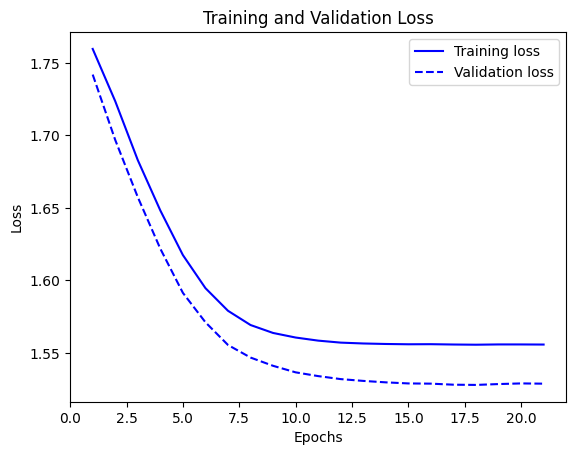

In [143]:
plot_loss(history)

In [144]:
def plot_accuracy(history):
    plt.clf()
    history_dict = history.history
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, len(acc_values)+ 1)
    plt.plot(epochs, acc_values, 'b', label = 'Training accuracy')
    plt.plot(epochs, val_acc_values, 'b--', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

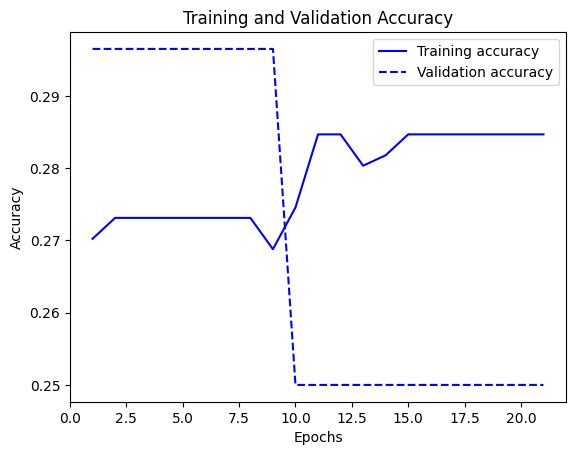

In [145]:
plot_accuracy(history)

In [146]:
results = my_first_model.evaluate(X_test, y_test_one_hot)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

7/7 [==============================] - 0s 15ms/step - loss: 2.0767 - accuracy: 0.1667
Test Loss: 2.076655864715576
Test Accuracy: 0.1666666716337204


In [147]:
print(my_first_model.predict(X_test))
#print(X_test[0:1])
#print(X_test[-1:])

7/7 [==============================] - 0s 9ms/step
[[0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 ...
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]
 [0.27105483 0.27100226 0.28705823 0.05959012 0.05255397 0.05874066]]


In [53]:
# def leave_one_out_train(X, y, model):
#     callbacks =  [
#     tf.keras.callbacks.EarlyStopping(
#         monitor = 'val_loss', 
#         patience=3
#     ),
#     tf.keras.callbacks.TensorBoard()
#     ]

#     losses = []
#     accuracies = []
#     for i in range(len(y)):
#         #print(y.shape)
#         y_train = y.copy()
#         y_test = pd.Series(y_train[i])
#         y_train.drop(i, inplace=True)
    #     #print(y_train.shape)
    #     #print(y_test.shape)
    #     #print(X.shape)
    #     X_train = X.copy()
    #     X_test = pd.DataFrame(X.iloc[i,:]).transpose()
    #     X_train.drop([i], inplace=True)
    #     #print(X_train.shape)
    #     #print(X_test.shape)

    #     model.fit(X_train, y_train, epochs = 10, batch_size = 1, callbacks = callbacks)
    #     error = model.evaluate(X_test, y_test)
    #     losses.append(error[0])
    #     accuracies.append(error[1])
    #     print(f'Finished round {i+1}')
    # return losses, accuracies


In [135]:
loss_list, accuracy_list = leave_one_out_train(X, y, my_first_model)

Epoch 1/10
29/29 [==============================] - 0s 11ms/step - loss: 0.5564 - accuracy: 0.7586
Epoch 2/10
29/29 [==============================] - 0s 17ms/step - loss: 0.5564 - accuracy: 0.7586
Epoch 3/10
29/29 [==============================] - 0s 10ms/step - loss: 0.5564 - accuracy: 0.7586
Epoch 4/10
29/29 [==============================] - 0s 8ms/step - loss: 0.5563 - accuracy: 0.7586
Epoch 5/10
29/29 [==============================] - 0s 7ms/step - loss: 0.5562 - accuracy: 0.7586
Epoch 6/10
29/29 [==============================] - 0s 10ms/step - loss: 0.5563 - accuracy: 0.7586
Epoch 7/10
29/29 [==============================] - 0s 8ms/step - loss: 0.5562 - accuracy: 0.7586
Epoch 8/10
29/29 [==============================] - 0s 7ms/step - loss: 0.5561 - accuracy: 0.7586
Epoch 9/10
29/29 [==============================] - 0s 9ms/step - loss: 0.5561 - accuracy: 0.7586
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.2333 - accuracy: 1.0000
Finished round 1

In [136]:
print(f'Average Loss: {np.average(loss_list)}')
print(f'Average Accuracy: {np.average(accuracy_list)}')

Average Loss: 0.5477952286601067
Average Accuracy: 0.7666666666666667


In [137]:
#Create model
def build_network(X):
    normal_layer = layers.Normalization(axis=-1)
    normal_layer.adapt(np.array(X.values))
    model = tf.keras.Sequential()
    model.add(normal_layer)
    model.add(layers.Dense(20, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',
                           optimizer = 'rmsprop',
                           metrics = ['accuracy'])

    return model


In [138]:
model_v2 = build_network(X)

In [139]:
loss_list, accuracy_list = leave_one_out_train(X, y, model_v2)

Epoch 1/10
29/29 [==============================] - 1s 8ms/step - loss: 0.6905 - accuracy: 0.7241
Epoch 2/10
29/29 [==============================] - 0s 7ms/step - loss: 0.6863 - accuracy: 0.7586
Epoch 3/10
29/29 [==============================] - 0s 8ms/step - loss: 0.6827 - accuracy: 0.7586
Epoch 4/10
29/29 [==============================] - 0s 8ms/step - loss: 0.6791 - accuracy: 0.7586
Epoch 5/10
29/29 [==============================] - 0s 7ms/step - loss: 0.6756 - accuracy: 0.7586
Epoch 6/10
29/29 [==============================] - 0s 7ms/step - loss: 0.6722 - accuracy: 0.7586
Epoch 7/10
29/29 [==============================] - 0s 6ms/step - loss: 0.6689 - accuracy: 0.7586
Epoch 8/10
29/29 [==============================] - 0s 6ms/step - loss: 0.6657 - accuracy: 0.7586
Epoch 9/10
29/29 [==============================] - 0s 6ms/step - loss: 0.6625 - accuracy: 0.7586
Epoch 10/10
1/1 [==============================] - 0s 117ms/step - loss: 0.6221 - accuracy: 1.0000
Finished round 1
Ep

In [140]:
print(f'Average Loss: {np.average(loss_list)}')
print(f'Average Accuracy: {np.average(accuracy_list)}')

Average Loss: 0.605768033862114
Average Accuracy: 0.7666666666666667


In [141]:
#Create model
def build_network(X):
    normal_layer = layers.Normalization(axis=-1)
    normal_layer.adapt(np.array(X.values))
    model = tf.keras.Sequential()
    model.add(normal_layer)
    model.add(layers.Dense(20, activation = 'relu'))
    model.add(layers.Dense(10, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',
                           optimizer = 'rmsprop',
                           metrics = ['accuracy'])

    return model

In [142]:
model_v3 = build_network(X)

In [143]:
loss_list, accuracy_list = leave_one_out_train(X, y, model_v3)

Epoch 1/10
29/29 [==============================] - 1s 18ms/step - loss: 0.6910 - accuracy: 0.7241
Epoch 2/10
29/29 [==============================] - 0s 10ms/step - loss: 0.6869 - accuracy: 0.7586
Epoch 3/10
29/29 [==============================] - 0s 7ms/step - loss: 0.6832 - accuracy: 0.7586
Epoch 4/10
29/29 [==============================] - 0s 8ms/step - loss: 0.6796 - accuracy: 0.7586
Epoch 5/10
29/29 [==============================] - 0s 9ms/step - loss: 0.6761 - accuracy: 0.7586
Epoch 6/10
29/29 [==============================] - 1s 18ms/step - loss: 0.6727 - accuracy: 0.7586
Epoch 7/10
29/29 [==============================] - 0s 11ms/step - loss: 0.6694 - accuracy: 0.7586
Epoch 8/10
29/29 [==============================] - 0s 7ms/step - loss: 0.6661 - accuracy: 0.7586
Epoch 9/10
29/29 [==============================] - 0s 8ms/step - loss: 0.6630 - accuracy: 0.7586
Epoch 10/10
1/1 [==============================] - 0s 131ms/step - loss: 0.6230 - accuracy: 1.0000
Finished round 

In [145]:
print(f'Average Loss: {np.average(loss_list)}')
print(f'Average Accuracy: {np.average(accuracy_list)}')

Average Loss: 0.6060270840922991
Average Accuracy: 0.7666666666666667
